# Benchmark
This notebook performs a performance comparison between different models using the DUD-E dataset.

The models in the benchmark are:
* Our atom/surface-level ensemble (DENVIS) trained on PDBbind general set (DENVIS-G).
* Our atom/surface-level ensemble (DENVIS) trained on PDBbind refined set (DENVIS-R).
* GNINA
* Vina
* RF-score
* NN-score
* DeepDTA
* Gold
* Glide
* Surflex
* FlexX
* Our ligand baseline trained on PDBbind refined set.

We compare AUROC, EF1 and BedROC metrics. For each model we have one group comprising multiple targets. For micro-average scores we use median (as we make no assumptions regarding distributions of metrics).

For statistical analysis, we perform group comparisons using the Friedman test and post-hoc comparisons using Wilcoxon signed-rank tests with Sidak correction (non-parametric).

In [1]:
import os
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import ensembling
import filtering
import metrics
import parsing
import plotting_utils
import postprocessing

# 1. Configuration

In [2]:
AVG_FUN = np.nanmedian  # Reduce function to compute averages across targets. Using nanmedian because there is one target missing from RF/NN-score
EF_ALPHA = 0.01 # alpha for EF metric (i.e., EF1)
BEDROC_ALPHA = 80.5 # alpha for BedROC metric (i.e, BedROC80.5)

PERFORMANCE_METRICS = ['AUROC', 'EF1', 'BEDROC80.5']
DATASET = 'DUD-E'

MAIN_PATH = '../data/outputs'
PROTEIN_LIGAND_PAIR_REDUCE = 'max'  # Reduce function for protein-ligand pairs multiple entries (e.g. Vina, docking, RF/NN-score etc.)
PAIR_ID_COLS = ['target_id', 'ligand_id']  # Specifies a unique protein-ligand pair

PATH_RESULTS = {
    'DENVIS-G': {
        'atom': os.path.join(MAIN_PATH, 'denvis_outputs', 'dude_main_general_atom.parquet'),
        'surface': os.path.join(MAIN_PATH, 'denvis_outputs', 'dude_main_general_surface.parquet'),},
    'DENVIS-R': {
        'atom': os.path.join(MAIN_PATH, 'denvis_outputs', 'dude_main_refined_atom.parquet'),
        'surface': os.path.join(MAIN_PATH, 'denvis_outputs', 'dude_main_refined_surface.parquet')},
    'Ligand bsl.': os.path.join(MAIN_PATH, 'denvis_outputs', 'dude_main_refined_ligand_bsl.parquet'),
    'GNINA': os.path.join(MAIN_PATH, 'gnina_outputs', 'newdefault_CNNaffinity-max.summary'),
    'Vina': os.path.join(MAIN_PATH, 'vina_outputs', 'dude.csv'),
    'RF-score': os.path.join(MAIN_PATH, 'rfnn_dude_scores'),
    'NN-score': os.path.join(MAIN_PATH, 'rfnn_dude_scores'),
    'Deep DTA': os.path.join(MAIN_PATH, 'deepdta_outputs', 'dude_trained_pdbbind.json'),
    'Gold': os.path.join(MAIN_PATH, 'docking_performance_scores', 'gold.csv'),
    'Glide': os.path.join(MAIN_PATH, 'docking_performance_scores', 'glide.csv'),
    'Surflex': os.path.join(MAIN_PATH, 'docking_performance_scores', 'surflex.csv'),
    'Flexx': os.path.join(MAIN_PATH, 'docking_performance_scores', 'flexx.csv')
}

# Network output aggregation kwargs for refined/general models
# General models have three outpus (Kd, Ki, IC50), refined models have two (Ki, Kd)
OUTPUT_COMBINATION_KWS = {
    'DENVIS-G': {'y_aff_weight': 0., 'y_kd_weight': 0.5, 'y_ki_weight': 0.5, 'y_ic50_weight': 0.5, 'use_clf': False, 'clf_strategy': None},
    'DENVIS-R': {'y_aff_weight': 0., 'y_kd_weight': 0.5, 'y_ki_weight': 0.5, 'y_ic50_weight': 0.0, 'use_clf': False, 'clf_strategy': None},
    'Ligand bsl.': {'y_aff_weight': 0., 'y_kd_weight': 0.5, 'y_ki_weight': 0.5, 'y_ic50_weight': 0.0, 'use_clf': False, 'clf_strategy': None},
}

# 2. Parse results

In [3]:
results = dict()  # key-value pairs that will store the outputs DataFrame instances

# For DENVIS, we have two models, one trained on PDBBind general and one trained on PDBbind refined sets.
for model in ['DENVIS-G', 'DENVIS-R']:
    results_cache = dict()
    print(f"Parsing {model} results...")
    # For each case we have two different types of model, depending on protein representation used: atom-level and surface-level
    for protein_model in ['atom', 'surface']:
        results_tmp, _ = parsing.parse_results_denvis(PATH_RESULTS[model][protein_model])
        results_cache[protein_model] = ensembling.compute_ensemble_scores(results_tmp, version=True, pair_id_cols=PAIR_ID_COLS)  # Multi-run ensembles
    
    
    results_ens = ensembling.compute_level_ensemble_scores(
        results_cache['atom'], results_cache['surface'], atom_weight=0.5, use_target_intersection=False, pair_id_cols=PAIR_ID_COLS)  # Multi-level (atom/surface) ensemble
    results_ens = postprocessing.combine_outputs(results_ens, **OUTPUT_COMBINATION_KWS[model])  # Aggregate model outputs
    results[model] = results_ens

print(f"Parsing ligand baseline results (refined)...")
model = 'Ligand bsl.'
results_tmp, _ = parsing.parse_results_denvis(PATH_RESULTS[model])  
results_tmp = ensembling.compute_ensemble_scores(results_tmp, version=True, pair_id_cols=PAIR_ID_COLS)
results_tmp = postprocessing.combine_outputs(results_tmp, **OUTPUT_COMBINATION_KWS[model])
results[model] = results_tmp

print(f"Parsing DeepDTA results...")
model = 'Deep DTA'
results[model] = parsing.parse_results_deeppurpose(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE)

print(f"Parsing Vina results...")
model = 'Vina'
results[model] = parsing.parse_results_vina(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE)  

print(f"Parsing GNINA results...")
model = 'GNINA'
results[model] = parsing.parse_results_gnina(PATH_RESULTS[model])

print(f"Parsing NN-score results...")
model = 'NN-score'
results[model] = parsing.parse_results_nn_score(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE, prog_bar=True)

print(f"Parsing RF-score results...")
model = 'RF-score'
results[model] = parsing.parse_results_rf_score(PATH_RESULTS[model], reduce=PROTEIN_LIGAND_PAIR_REDUCE, prog_bar=True)

Parsing DENVIS-G results...


/Users/nickantonopoulos/miniconda3/envs/denvis/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Parsing DENVIS-R results...
Parsing ligand baseline results (refined)...
Parsing DeepDTA results...
Parsing Vina results...
Parsing GNINA results...
Parsing NN-score results...


100%|███████████████████████████████████████████████████████| 101/101 [12:05<00:00,  7.19s/it]


Parsing RF-score results...


100%|███████████████████████████████████████████████████████| 101/101 [11:03<00:00,  6.56s/it]


# 3. Identify missing targets
A few methods have missing targets. We will identify them here so that we can add `nan` entries in the respective DataFrames later to enable fair comparisons between the algorithms.

In [4]:
filtering_list = []
for _, result in results.items():
    filtering_list.append(list(result.target_id.unique()))
target_union = filtering.target_union(filtering_list)

missing_targets = dict()  # One entry per model
for model, result in results.items():
    taget_diff = (set(target_union)) - set(result.target_id.unique())
    missing_targets[model] = taget_diff
    print(f'Missing targets, {model}: {missing_targets[model]}')

Missing targets, DENVIS-G: set()
Missing targets, DENVIS-R: set()
Missing targets, Ligand bsl.: set()
Missing targets, Deep DTA: set()
Missing targets, Vina: set()
Missing targets, GNINA: set()
Missing targets, NN-score: {'csf1r'}
Missing targets, RF-score: {'csf1r'}


# 4. Benchmark

## 4.1 Compute performance scores

In [5]:
results_tf = pd.DataFrame(columns=['Dataset', 'Model'] + PERFORMANCE_METRICS)  # micro-average DataFrame (tidy-format)
results_pt_tf = pd.DataFrame(columns=['Dataset', 'Model', 'Target'] + PERFORMANCE_METRICS)  # Per-targety DataFrame (tidy-format)

for model, result in results.items():
    # Compute per-target and micro-average scores
    auroc_pt, auroc_micro = metrics.compute_auroc_scores(result, avg_fun=AVG_FUN)
    ef1_pt, ef1_micro = metrics.compute_ef_scores(result, alpha=EF_ALPHA, avg_fun=AVG_FUN)
    bedroc805_pt, bedroc805_micro = metrics.compute_bedroc_scores(result, alpha=BEDROC_ALPHA, avg_fun=AVG_FUN)

    # Update micro DataFrame
    results_tf = pd.concat((results_tf, pd.DataFrame.from_records({
        'Dataset': DATASET,
        'Model': model,
        'AUROC': auroc_micro,
        'EF1': ef1_micro,
        'BEDROC80.5': bedroc805_micro}, 
        index=[len(results_tf)])))

    new_df_pt = pd.DataFrame.from_records(
        [auroc_pt, ef1_pt, bedroc805_pt],
        index=['AUROC', 'EF1', 'BEDROC80.5']).T.reset_index(level=0, inplace=False).rename({'index': 'Target'}, axis=1, inplace=False)
    # If there are missing targets for this model, add entries with nan values (to make statistical comparisons feasible)
    if len(missing_targets[model]):
        for missing_target in missing_targets[model]:
            new_df_pt = pd.concat(
                (new_df_pt, pd.DataFrame({
                    'Target': missing_target,
                    'AUROC': np.nan,
                    'EF1': np.nan,
                    'BEDROC80.5': np.nan},
                    index=[len(new_df_pt)])), axis='index')
    new_df_pt.insert(0, 'Dataset', DATASET)
    new_df_pt.insert(1, 'Model', model)
    results_pt_tf = pd.concat((results_pt_tf, new_df_pt))

## 4.2 Append performance scores for docking methods
For the four docking methods (Gold, Glide, Surflex, Flexx), the raw outputs (i.e., scores) are not available. For this reason, we provide the computed performance scores for each method per-target. We append these results in the DataFrames computed above.

In [6]:
for model in ['Gold', 'Glide', 'Surflex', 'Flexx']:
    # Update per-target DataFrame
    new_df_pt = pd.read_csv(PATH_RESULTS[model])
    new_df_pt.insert(0, 'Dataset', DATASET)
    new_df_pt.insert(1, 'Model', model)
    results_pt_tf = pd.concat((results_pt_tf, new_df_pt))
    
    # Update micro-average DataFrame
    results_tf = pd.concat((results_tf, pd.DataFrame.from_records({
        'Dataset': DATASET,
        'Model': model,
        'AUROC': AVG_FUN(new_df_pt['AUROC']),
        'EF1': AVG_FUN(new_df_pt['EF1']),
        'BEDROC80.5': AVG_FUN(new_df_pt['BEDROC80.5'])},
        index=[len(results_tf)])))

## 4.3 Micro-average score benchmark (Table 3)

In [7]:
print_order = ['DENVIS-G', 'DENVIS-R', 'Deep DTA', 'Gold', 'Glide', 'Surflex', 'Flexx', 'Vina', 'GNINA', 'RF-score', 'NN-score', 'Ligand bsl.']
cols = ['AUROC', 'EF1', 'BEDROC80.5']
print_df = results_tf.set_index('Model').loc[print_order][cols].round(decimals=2)
print_df

,AUROC,EF1,BEDROC80.5
Model,,,
DENVIS-G,0.92,38.92,0.66
DENVIS-R,0.86,18.37,0.33
Deep DTA,0.58,1.62,0.04
Gold,0.86,21.08,0.39
Glide,0.82,21.96,0.35
Surflex,0.75,9.36,0.19
Flexx,0.76,10.10,0.20
Vina,0.75,6.84,0.14
GNINA,0.79,15.48,0.29


## 4.4 Per-target benchmark (Figure 3)

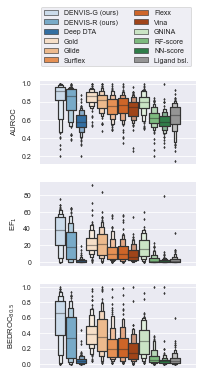

In [8]:
sns.set_context("paper", font_scale=.8, rc={"lines.linewidth": 1.5})
hue_order = ['DENVIS-G', 'DENVIS-R', 'Deep DTA', 'Gold', 'Glide', 'Surflex', 'Flexx', 'Vina', 'GNINA', 'RF-score', 'NN-score', 'Ligand bsl.']
color_palette = sns.color_palette("Blues", 3) + sns.color_palette("Oranges", 5) + sns.color_palette("Greens", 3) + sns.color_palette("Greys", 1)
metrics_ = ['AUROC', 'EF1', 'BEDROC80.5']

showfliers = True
fliersize = 1
linewidth = 1.2
figsize = (2.8,5.3)
leg_pos = (-0.01, 1.9)

label_alias = {
    'DENVIS-G': 'DENVIS-G (ours) ',
    'DENVIS-R': 'DENVIS-R (ours)',
    'GNINA': 'GNINA',
    'Vina': 'Vina',
    'RF-score': 'RF-score',
    'NN-score': 'NN-score',
    'Deep DTA': 'Deep DTA',
    'Ligand bsl.': 'Ligand bsl.',
    'Gold': 'Gold',
    'Glide': 'Glide',
    'Surflex': 'Surflex',
    'Flexx': 'Flexx'
}

fig, ax = plt.subplots(figsize=figsize, nrows=3, ncols=1)
for i, metric in enumerate(metrics_):
    sns.boxenplot(
        data=results_pt_tf,
        x='Dataset',
        order=['DUD-E'],
        hue='Model',
        y=metric,
        hue_order=hue_order,
        palette=color_palette,
        showfliers=showfliers,
        linewidth=linewidth,
        ax=ax[i])


# Legend options
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, labels=[label_alias[l] for l in labels], bbox_to_anchor=leg_pos, loc='upper left', ncol=2)

for ax_ in ax:
    ax_.set_xticklabels([])
    ax_.set_xlabel('')
    # Temporary workaround for setting fliersize for boxenplot
    # see: https://github.com/mwaskom/seaborn/issues/2701
    plt.setp(ax_.collections[::2], sizes=[2 ** fliersize])

for ax_ in ax[1:]:
    ax_.legend().remove()

ax[1].set_ylabel(r'EF$_{1}$')
ax[2].set_ylabel(r'BEDROC$_{80.5}$')
plt.show()

## 4.5 One-to-one comparisons (Figure 4)
* DENVIS-R vs. GNINA
* DENVIS-G vs. Gold

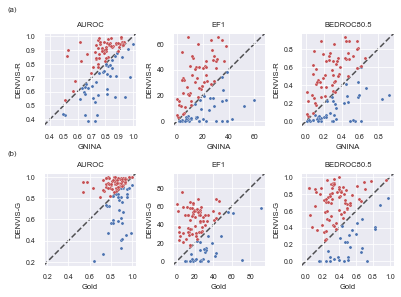

In [9]:
sns.set_context("paper", font_scale=.8, rc={"lines.linewidth": 1.5})
figsize = (5.5,4.)
size = 10
aspect_ratio = 0.7
aspect_ratio = 1.0

# Colors are defined in the cell above, we just index them here
denvis_g_col = color_palette[0]
denvis_r_col = color_palette[1]
gnina_col = color_palette[9]
gold_col = color_palette[4]
col_1, col_2 = sns.color_palette('Paired')[8:10]
col_1, col_2 = sns.color_palette(n_colors=4)[0], sns.color_palette(n_colors=4)[3]


fig, ax = plt.subplots(figsize=figsize, nrows=2, ncols=3)
comparisons = [
    ('DENVIS-R', 'GNINA'),
    ('DENVIS-G', 'Gold')]

for row_id, comparison in enumerate(comparisons):
    for col_id, metric in enumerate(PERFORMANCE_METRICS):
        our_scores = results_pt_tf[(results_pt_tf['Model']==comparison[0])][metric].values
        other_scores = results_pt_tf[(results_pt_tf['Model']==comparison[1])][metric].values
        
        sns.scatterplot(
            x=other_scores[other_scores > our_scores],
            y=our_scores[other_scores > our_scores],
            color=col_1,
            s=size,
            ax=ax[row_id, col_id])
        sns.scatterplot(
            x=other_scores[other_scores < our_scores],
            y=our_scores[other_scores < our_scores],
            color=col_2,
            s=size,
            ax=ax[row_id, col_id])
        plotting_utils.plot_diagonal_line(ax[row_id, col_id])
        ax[row_id, col_id].set_ylabel(comparison[0])
        ax[row_id, col_id].set_xlabel(comparison[1])
        ax[row_id, col_id].set_title(metric)

# Tidy-up
for ax_ in ax.reshape(-1,):
    ax_.set_xticks(ax_.get_yticks()[1:-1])
    ax_.set_yticks(ax_.get_yticks()[1:-1])
          
fig.text(0, 1.0, '(a)')
fig.text(0, 0.5, '(b)')
fig.tight_layout()
plt.show()

## 4.6 Statitical analysis (Table 4)

In [10]:
pd.options.display.float_format = '{:.2e}'.format

def statistical_notation(p_val):
    if p_val < 1e-3:
        res = '***'
    elif p_val < 1e-2:
        res = '**'
    elif p_val < 0.05:
        res = '*'
    else:
        res = 'n.s.'
    
    return res

comparisons = [
    ('DENVIS-G', 'DENVIS-R'),
    ('DENVIS-R', 'GNINA'),
    ('DENVIS-G', 'Gold'),
    ('DENVIS-G', 'Glide'),
    ('DENVIS-R', 'Deep DTA'),
    ('DENVIS-G', 'Ligand bsl.'),
    ('DENVIS-R', 'Ligand bsl.'),
    ('GNINA', 'Ligand bsl.'),
    ('Deep DTA', 'Ligand bsl.'),
    ('Vina', 'Ligand bsl.'),
    ('RF-score', 'Ligand bsl.'),
    ('NN-score', 'Ligand bsl.'),
    ('Gold', 'Ligand bsl.'),
    ('Surflex', 'Ligand bsl.'),
    ('Flexx', 'Ligand bsl.'),
    ('Glide', 'Ligand bsl.'),
]
perf_metrics = ['AUROC', 'EF1', 'BEDROC80.5']
label_alias = {
    'DENVIS-G': 'DENVIS-G',
    'DENVIS-R': 'DENVIS-R',
    'GNINA': 'GNINA',
    'Vina': 'Vina',
    'RF-score': 'RF-score',
    'NN-score': 'NN-score',
    'Deep DTA': 'Deep DTA',
    'Ligand bsl.': 'Ligand baseline',
    'Gold': 'Gold',
    'Glide': 'Glide',
    'Surflex': 'Surflex',
    'Flexx': 'Flexx'}

df_comparison = pd.DataFrame(columns=['Model 1', 'Model 2'] + PERFORMANCE_METRICS)
df_comparison['Model 1'] = [model[0] for model in comparisons]
df_comparison['Model 2'] = [model[1] for model in comparisons]

multcompare_method = 'sidak'

for perf_metric in PERFORMANCE_METRICS:
    friedman_pval = pg.friedman(data=results_pt_tf, dv=perf_metric, within='Model', subject='Target')['p-unc']['Friedman']
    
    p_val_uncorr = []
    n_comparisons = len(comparisons)
    for comparison in comparisons:
        model_x, model_y = comparison
        x = results_pt_tf[results_pt_tf['Model']==model_x].set_index('Target').sort_index()[perf_metric].values
        y = results_pt_tf[results_pt_tf['Model']==model_y].set_index('Target').sort_index()[perf_metric].values
        p_val_uncorr.append(pg.wilcoxon(x=x, y=y, alternative='two-sided')['p-val']['Wilcoxon'])

    # Perform multiple comparisons
    nh_reject, p_val_corr = pg.multicomp(pvals=p_val_uncorr, alpha=0.05, method=multcompare_method)
    df_comparison[perf_metric] = p_val_corr

for perf_metric in perf_metrics:
    df_comparison[perf_metric] = df_comparison.apply(lambda row: statistical_notation(row[perf_metric]), axis=1)

print_df = df_comparison.replace(to_replace=label_alias).set_index(['Model 1', 'Model 2'])
print_df.index.names = None, None
print_df

AUROC   EF1 BEDROC80.5
DENVIS-G DENVIS-R          ***   ***        ***
DENVIS-R GNINA            n.s.  n.s.       n.s.
DENVIS-G Gold             n.s.   ***        ***
         Glide              **   ***        ***
DENVIS-R Deep DTA          ***   ***        ***
DENVIS-G Ligand baseline   ***   ***        ***
DENVIS-R Ligand baseline   ***   ***        ***
GNINA    Ligand baseline   ***   ***        ***
Deep DTA Ligand baseline    **  n.s.       n.s.
Vina     Ligand baseline   ***   ***        ***
RF-score Ligand baseline  n.s.  n.s.       n.s.
NN-score Ligand baseline     *  n.s.       n.s.
Gold     Ligand baseline   ***   ***        ***
Surflex  Ligand baseline   ***   ***        ***
Flexx    Ligand baseline   ***   ***        ***
Glide    Ligand baseline   ***   ***        ***

## 4.7 Table per-target comparisons (Tables S1, S2, S3)

In [11]:
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 120
pd.set_option('display.expand_frame_repr', False) 

perf_metrics = ['AUROC', 'EF1', 'BEDROC80.5']
columns_order = ['DENVIS-G', 'DENVIS-R', 'Deep DTA', 'Gold', 'Glide', 'Surflex', 'Flexx', 'Vina', 'GNINA', 'RF-score', 'NN-score', 'Ligand bsl.']
columns_alias = {
    'DENVIS-G': 'D-G',
    'DENVIS-R': 'D-R',
    'GNINA': 'GNINA',
    'Vina': 'Vina',
    'RF-score': 'RF',
    'NN-score': 'NN',
    'Deep DTA': 'DDTA',
    'Ligand bsl.': 'Bsl.',
    'Gold': 'Gold',
    'Glide': 'Glide',
    'Surflex': 'Surflex',
    'Flexx': 'Flexx'}

for metric in perf_metrics:
    print_df = pd.pivot(results_pt_tf, index='Target', columns='Model', values=metric)
    print_df.columns.name, print_df.index.name = None, None
    print_df = print_df[columns_order].rename(columns=columns_alias)
    print(metric)
    print('--------------------------------------------------------------------------------------')
    print(print_df)
    print('\n')

AUROC
--------------------------------------------------------------------------------------
        D-G  D-R  DDTA  Gold  Glide  Surflex  Flexx  Vina  GNINA   RF   NN  Bsl.
aa2ar  0.84 0.43  0.59  0.87   0.80     0.77   0.74  0.65   0.74 0.50 0.54  0.57
abl1   0.89 0.90  0.65  0.90   0.74     0.76   0.85  0.78   0.79 0.68 0.62  0.81
ace    0.90 0.96  0.41  0.74   0.72     0.77   0.61  0.56   0.61 0.67 0.75  0.40
aces   0.81 0.82  0.62  0.75   0.67     0.73   0.57  0.78   0.62 0.66 0.65  0.67
ada    0.99 0.99  0.61  0.91   0.68     0.83   0.55  0.57   0.76 0.61 0.58  0.61
ada17  0.99 0.98  0.50  0.77   0.81     0.92   0.60  0.71   0.82 0.66 0.69  0.70
adrb1  0.90 0.62  0.54  0.86   0.88     0.80   0.76  0.73   0.63 0.68 0.58  0.34
adrb2  0.89 0.64  0.56  0.87   0.88     0.81   0.84  0.71   0.71 0.62 0.61  0.35
akt1   0.88 0.96  0.79  0.91   0.78     0.63   0.73  0.76   0.76 0.63 0.49  0.71
akt2   0.87 0.91  0.72  0.94   0.85     0.77   0.86  0.79   0.81 0.56 0.65  0.65
aldr   0.56 0.60